In [1]:
import pandas as pd
import os
import json
import torch
import numpy as np
from torch.utils.data import DataLoader
from steams.data import KVyQVx
from steams.models.attention import madsnn2
from steams.trainer import AttentionTrainer,train, evaluation, prediction_prime, ensemble_prime
from steams.criterion import R2,RMSE,variance
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import geopandas as gpd

In [2]:
# parent_path = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))
# parent_dir = os.path.join(parent_path,'results','NWnn3')
# if not os.path.exists(parent_dir):
#     os.makedirs(parent_dir)

parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))


In [3]:
resdir = os.path.join(parent_dir,'results')
figdir = os.path.join(parent_dir,'fig')
if not os.path.exists(figdir):
    os.makedirs(figdir)
if not os.path.exists(resdir):
    os.makedirs(resdir)

In [4]:
if torch.cuda.is_available():
    cuda_name = "1"
    num_workers=0
    pin_memory = True
    device = torch.device('cuda'+":"+cuda_name)
    #device = torch.device('cuda')
else:
    num_workers = 4
    pin_memory = False
    device = torch.device('cpu')

In [5]:
device

device(type='cpu')

## train/valid dataset

In [6]:
params = {
        "class" : "KVyQVx",
        "Y":{
          "path": "",
          "KEY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "history_length": 0,
          "nb_sampling": 100
        },
        "X":{
          "path": "",
          "QUERY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "gap_length": 0,
          "horizon_length":0,
          "nb_sampling": 100
        }
    }

In [7]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_train")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_train")

train_dataset = KVyQVx(params)

In [8]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_valid")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_valid")

valid_dataset = KVyQVx(params)

In [9]:
#train_dataset[0]

## model, optimizer, criterion, scheduler

In [10]:
#model
model = madsnn2(device,type="nwd",kernel="gauss", input_k=2,input_q=2, input_v=1, hidden_size=32)

In [15]:
# optimzer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) #8e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# criterion
criterion = torch.nn.MSELoss()

# AttentionTrainer object
obj = AttentionTrainer(model,device)
obj.init_optimizer(optimizer)
obj.init_criterion(criterion)

## Training

In [16]:
# training
train(obj,train_dataset,valid_dataset,niter=200,n_iter_stop=20,batch_size=64,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

  epoch     train     valid
0     0  0.143365  0.060302
  epoch    train     valid
0     1  0.14441  0.060569
  epoch     train    valid
0     2  0.143183  0.06108
  epoch     train     valid
0     3  0.143731  0.061887
  epoch     train     valid
0     4  0.143031  0.061059
  epoch     train     valid
0     5  0.143264  0.060783
  epoch     train     valid
0     6  0.140978  0.061207
  epoch     train     valid
0     7  0.144292  0.060589
  epoch     train    valid
0     8  0.141335  0.06066
  epoch     train     valid
0     9  0.143189  0.060474
  epoch     train     valid
0    10  0.142715  0.060664
  epoch     train     valid
0    11  0.145495  0.060829
  epoch     train    valid
0    12  0.142988  0.06073
  epoch     train     valid
0    13  0.142423  0.060874
  epoch     train     valid
0    14  0.144164  0.061325
  epoch     train     valid
0    15  0.144865  0.059938
  epoch    train     valid
0    16  0.14512  0.061205
  epoch     train     valid
0    17  0.145644  0.060723
  

In [17]:
obj.save_model(resdir,"1c-nwdnn2")

## Or load model

In [18]:
obj.load_model(resdir,"1c-nwdnn2")

/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:265: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(model_path))


## Evaluation

In [19]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [20]:
criterion = R2()
obj.init_criterion(criterion)

In [21]:
evaluation(obj,eval_dataset,batch_size=64,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.9037899933755398


In [22]:
criterion = RMSE()
obj.init_criterion(criterion)

In [23]:
evaluation(obj,eval_dataset,batch_size=64,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

32.89343595504761


In [24]:
criterion = variance()
obj.init_criterion(criterion)

In [25]:
evaluation(obj,eval_dataset,batch_size=64,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

625.0154838562012


## QQplot

In [26]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [27]:
results = prediction_prime(obj,eval_dataset)

/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,tmp_df],ignore_index=True,axis=0)


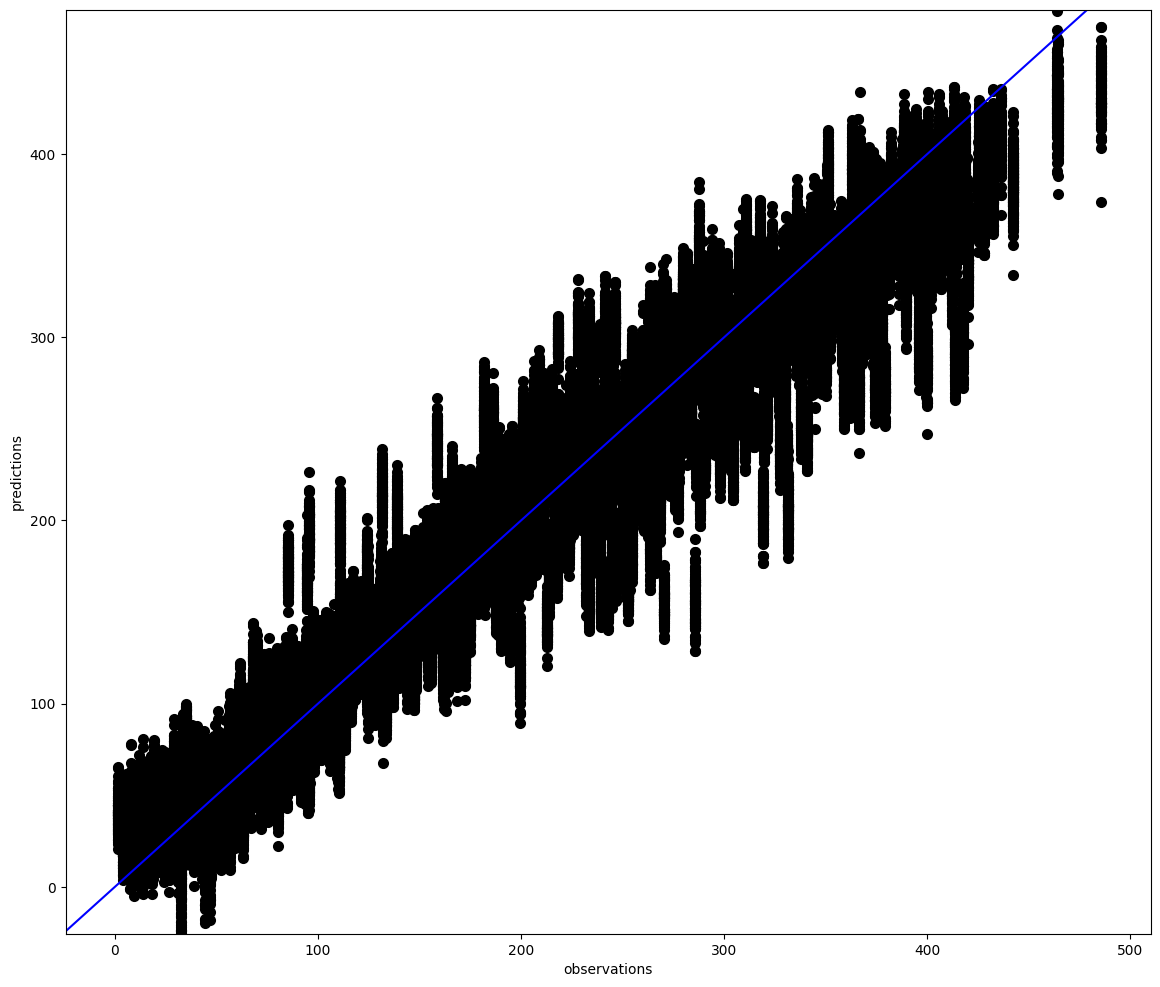

In [28]:
pred_name = ['pred_' + v for v in eval_dataset.VALUE_X]

fig, ax= plt.subplots(figsize=(14, 12))
ax.scatter(results.loc[:,eval_dataset.VALUE_X],results.loc[:,pred_name], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
# ax.set_xlim(0, 2.5)
ax.set_ylim(results.loc[:,pred_name].min().item()-0.5, results.loc[:,pred_name].max().item()+0.5)
ax.set(xlabel='observations', ylabel='predictions')

fig_filename = os.path.join(parent_dir,'fig','1c-qqplot.png')
plt.savefig(fig_filename, dpi = 300)

## Illustration of a 2d-map prediction

In [29]:
params = {
        "class" : "KVyQVx",
        "Y":{
          "path": "",
          "KEY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "history_length": 0,
          "nb_sampling": 100
        },
        "X":{
          "path": "",
          "QUERY":["x","y"],
          "VALUE": ["ref"],
          "nb_location" : 6400,
          "gap_length": 0,
          "horizon_length":0,
          "nb_sampling": 6400
        }
    }

In [30]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_all_6400")

eval_dataset = KVyQVx(params)

In [31]:
eval_dataset.scale(True)
KEY_Y,VALUE_Y,QUERY_X, VALUE_X = eval_dataset[0]
QUERY_res, VALUE_res = obj.predict(KEY_Y,VALUE_Y,QUERY_X,eval_dataset)

In [32]:
# output
VALUE_X = torch.reshape(VALUE_X,(1,VALUE_X.shape[0],VALUE_X.shape[1]))
#QUERY_X_unscale = eval_dataset.unscale(QUERY_X,"QUERY").to(device)
VALUE_X_unscale = eval_dataset.unscale(VALUE_X,"VALUE_X").to(device)

In [33]:
tmp = np.concatenate((QUERY_res, VALUE_res,VALUE_X_unscale),2)
tmp = np.reshape(tmp,(tmp.shape[1],tmp.shape[2]))
results = pd.DataFrame(tmp,columns=['x','y','values','truth'])   

In [34]:
# predictors
VALUE_Y = torch.reshape(VALUE_Y,(1,VALUE_Y.shape[0],VALUE_Y.shape[1]))
KEY_Y = torch.reshape(KEY_Y,(1,KEY_Y.shape[0],KEY_Y.shape[1]))
KEY_Y_unscale = eval_dataset.unscale(KEY_Y,"KEY").to(device)
VALUE_Y_unscale = eval_dataset.unscale(VALUE_Y,"VALUE_Y").to(device)

tmp = np.concatenate((KEY_Y_unscale, VALUE_Y_unscale),2)
tmp = np.reshape(tmp,(tmp.shape[1],tmp.shape[2]))
predictors = pd.DataFrame(tmp,columns=['x','y','values'])        

In [35]:
vmax = np.array(
    results['values'].max(),
    results['truth'].max()).max()

vmin = np.array(
    results['values'].min(),
    results['truth'].min()).min()

In [36]:
foo = predictors.copy()
# unique_rmse = np.unique(foo["rmse"])
# unique_variance = np.unique(foo["variance"])
# symbol_rmse = [i for i in range(1,len(unique_rmse)+1)]
# symbol_variance = ['o','v','s','p','s','D']#[i for i in range(len(unique_variance))]


In [37]:
results

,x,y,values,truth
0,4349987.5,4095412.5,217.023071,189.325897
1,4342862.5,4089612.5,354.633667,398.304169
2,4347587.5,4092287.5,94.207993,127.254807
3,4348287.5,4097487.5,233.188950,258.611877
4,4343637.5,4095787.5,275.024780,217.579880
...,...,...,...,...
6395,4347387.5,4093537.5,287.527649,265.806885
6396,4344462.5,4091487.5,303.955444,323.358704
6397,4350662.5,4098162.5,394.248962,444.424347
6398,4347212.5,4094412.5,299.477234,354.124451


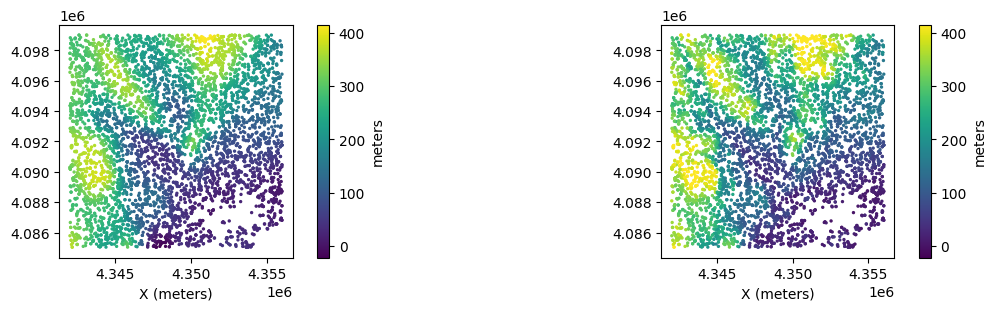

In [38]:
fig = plt.figure(constrained_layout=True,figsize=(12, 3))
gs = GridSpec(1, 2, figure=fig)

ax1 = fig.add_subplot(gs[0,0])
c1 = ax1.scatter(x=results["x"], y=results["y"], s=2,c=results['values'],vmin=vmin,vmax=vmax)
#ax1.set(ylabel='Y (meters)')
ax1.set(xlabel='X (meters)')
plt.gca().set_aspect("equal")

ax2 = fig.add_subplot(gs[0,1])
c2 = ax2.scatter(x=results["x"], y=results["y"], s=2,c=results['truth'],vmin=vmin,vmax=vmax)
#ax2.set(ylabel='Y (meters)')
ax2.set(xlabel='X (meters)')
plt.gca().set_aspect("equal")

fig.colorbar(c1, ax=ax1,label ='meters')
fig.colorbar(c2, ax=ax2,label ='meters')

fig_filename = os.path.join(parent_dir,'fig','illustration_prediction.png')
plt.savefig(fig_filename, dpi = 300)
